In [73]:
# helper functions

# get http request headers
def getHeaders():
    headers = {
        "apikey":akey,
        "accept":"application/json"
    }
    return headers


# GET /property/address via zip code
def fetch(url, params):
    headers = getHeaders()
    res = requests.get(url, headers=headers, params=params).json()
    return res


# show load bar and wait for next request
def wait(t):    
    sys.stdout.write('.')
    sys.stdout.flush()
    time.sleep(t)
    

def f(x):
    if x >= 10:
        return 10
    elif x <= 0:
        return 1
       
    else:
        return x 
    

def g(x):
    if x >= 5:
        return 10
    elif x <= 0:
        return 1
    else:
        return 5 
    
    
def h(x):
    return x['pt_rankStars'] + x['pt_rankStatewidePercentage'] + x['pt_averageStandardScore'] + x['pt_rankMovement'] + x['pt_pupilTeacherRatio']


def i(x):
    return (x['high_score'] + x['middle_score'] + x['elementary_score']) / 15


def k(x):
    if x >= 100:
        return 10
    elif x == 100:
        return 7.5
    elif x >= 50 and  x < 100:
        return 5
    elif x > 0 and  x < 50:
        return 1
    else:
        return 0


def l(x):
    return (x['score_grocery_stores'] + x['score_police_stations'] + x['score_transit_stations'] + x['score_museums']) / 4

In [ ]:
# Dependencies
import sys
import time
import json
import requests
import importlib
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from config import gkey, zkey, zws_id, akey

In [3]:
# get list of zipcodes
%run ./write_zips.ipynb
import zipcodes
importlib.reload(zipcodes)
required_zips = zipcodes.ziplist

Target city: atlanta
Search radius: 5


In [4]:
# get lat, lng coords from ziplist
url = "https://maps.googleapis.com/maps/api/geocode/json?"
response = []
latlngs = []

for z in required_zips:
    params = {
        "address":z,
        "key":gkey
    }

    res = requests.get(url, params=params).json()
    response.append({"response":res, "zipcode": z})

for r in response:
    try:
        zc = r['zipcode']
        lat = r['response']['results'][0]['geometry']['location']['lat']
        lng = r['response']['results'][0]['geometry']['location']['lng']
        
        latlngs.append({
            "lat":lat,
            "lng":lng,
            "zipcode":zc
        })

    except:
        continue

# Neighborhood Analysis

In [5]:
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
ttypes = ['grocery_or_supermarket', 'police', 'transit_station', 'museum']

zipcodes = []
target_coordinates = []

museums = []
grocery_stores = []
police_stations = []
transit_stations = []

sys.stdout.write('working..')

for l in latlngs:
    curzip = l['zipcode']
    curlatlng = f"{l['lat']},{l['lng']}"
    
    for i,t in enumerate(ttypes):
        curtype = t
        
        params = {
            "target_search": curtype,
            "location": curlatlng,
            "radius": 1609, # TODO: pull this in for dynamic search radius
            "type": curtype,
            "key":gkey
        }

        response = requests.get(base_url, params=params).json()

        wait(0)
        
        # populate list items
        for item in response["results"]:
            if(i == 0):
                grocery_stores.append({
                    "zipcode":curzip,    "loc":  curlatlng,
                    "item":item["name"], "type": curtype
                })
            elif(i == 1):
                police_stations.append({
                    "zipcode":curzip,    "loc":  curlatlng,
                    "item":item["name"], "type": curtype
                })
            elif(i == 2):
                transit_stations.append({
                    "zipcode":curzip,    "loc":  curlatlng,
                    "item":item["name"], "type": curtype
                })
            else:
                museums.append({
                    "zipcode":curzip,    "loc":  curlatlng,
                    "item":item["name"], "type": curtype
                })

............................................................................................................................................

In [370]:
# generate dataframes
gdf = pd.DataFrame(grocery_stores)
tdf = pd.DataFrame(transit_stations)
pdf = pd.DataFrame(police_stations)
mdf = pd.DataFrame(museums)

In [372]:
# group data by zipcode
grocery_count = gdf[['item', 'zipcode']].groupby('zipcode').count()
transit_count = tdf[['item', 'zipcode']].groupby('zipcode').count()
police_count = pdf[['item', 'zipcode']].groupby('zipcode').count()
museum_count = mdf[['item', 'zipcode']].groupby('zipcode').count()

In [373]:
# merge dataframes
gt_count = grocery_count.merge(transit_count, on='zipcode')
gt_count = gt_count.rename(columns={
    "item_x":"num_grocery_stores",
    "item_y":"num_transit_stations"
})

gtp_count = gt_count.merge(police_count, on='zipcode')
gtp_count = gtp_count.rename(columns={
    "item":"num_police_stations"
})

gtpm_count = gtp_count.merge(museum_count, on="zipcode")
gtpm_count = gtpm_count.rename(columns={
    "item":"num_museums"
})

In [374]:
# extract grocery stores, police stations, museums, transit stations and assign scores
average_grocery = gtpm_count["num_grocery_stores"].mean()
average_police = gtpm_count["num_police_stations"].mean()
average_museum = gtpm_count["num_museums"].mean()
average_transit_station = gtpm_count["num_transit_stations"].mean()

# assign scores
gtpm_count["avg_grocery_stores"] = (gtpm_count["num_grocery_stores"]/average_grocery*100).fillna(0.0).astype(int)
gtpm_count["avg_police_stations"] = (gtpm_count["num_police_stations"]/average_police*100).fillna(0.0).astype(int)
gtpm_count["avg_transit_stations"] = (gtpm_count["num_transit_stations"]/average_transit_station*100).fillna(0.0).astype(int)
gtpm_count["avg_museums"] = (gtpm_count["num_museums"]/average_museum*100 ).fillna(0.0).astype(int)

In [375]:
gtpm_count["score_grocery_stores"] = gtpm_count.apply(lambda row: k(row['avg_grocery_stores']), axis=1)
gtpm_count["score_police_stations"] = gtpm_count.apply(lambda row: k(row['avg_police_stations']), axis=1)
gtpm_count["score_transit_stations"] = gtpm_count.apply(lambda row: k(row['avg_transit_stations']), axis=1)
gtpm_count["score_museums"] = gtpm_count.apply(lambda row: k(row['avg_museums']), axis=1)
gtpm_count["total_score"] = gtpm_count.apply(lambda row: l(row), axis=1)
gtpm_count = gtpm_count.drop(columns=['num_grocery_stores','num_police_stations','num_transit_stations','num_museums',
                                      'avg_grocery_stores','avg_police_stations','avg_transit_stations','avg_museums'])
# gtpm_count

# Price Analysis

In [13]:
# get properties for each zip code (10 queries/min)
url = "https://search.onboard-apis.com/propertyapi/v1.0.0/assessment/detail?"
property_results = []
prop_types = ['RESIDENTIAL (NEC)', 'CONDOMINIUM', 
              'APARTMENT', 'CABIN', 'DUPLEX', 
              'MANUFACTURED HOME', 'MOBILE HOME',
              'TRIPLEX', 'TOWNHOUSE/ROWHOUSE']

sys.stdout.write('working..')

for z in latlngs:
    curzip = z['zipcode']
    
    for pt in prop_types:
        curpt = pt

        params = {
            "postalcode": curzip,
            "propertytype": curpt
        }

        res = fetch(url, params)

        property_results.append(res)
        wait(8)

working.............................................................................................................................................................................................................................................................................................................................

In [376]:
props_data = []
for p in property_results:
    try:
        for q in p['property']:
            props_data.append(q)
    except Exception as e:
        continue

In [378]:
prop_res = []
for p in property_results:
    try:
        for q in p['property']:
            zipcode = q['address']['postal1']
            mkt_val = q['assessment']['market']['mktttlvalue']
            prop_res.append({"zipcode":zipcode, "mkt_val":mkt_val})
    except Exception as e:
        print(e)

In [379]:
prop_df = pd.DataFrame(prop_res)
avg_mkt_val = round(prop_df.groupby(['zipcode']).sum() / len(prop_res), 2)
# avg_mkt_val

In [381]:
price_neighborhood_final_df = gtpm_count.merge(avg_mkt_val, on="zipcode") \
    .rename(columns={"mkt_val":"avg_mkt_val"})

price_neighborhood_final_df = price_neighborhood_final_df.drop(columns=[
    'score_grocery_stores','score_police_stations','score_transit_stations','score_museums'])
price_neighborhood_final_df = price_neighborhood_final_df.drop(['30317','30375'])
price_neighborhood_final_df = price_neighborhood_final_df.reset_index()
price_neighborhood_final_df = price_neighborhood_final_df.sort_values(by=['avg_mkt_val'], ascending=False)
# price_neighborhood_final_df

,zipcode,total_score,avg_mkt_val
6,30363,7.75,261123.71
1,30308,5.50,249129.35
0,30303,7.75,136101.63
3,30313,7.75,38016.63
2,30312,8.75,37320.32
4,30314,5.50,30652.85
5,30332,6.50,13714.10


# School Analysis

In [66]:
# Inititalize arrays for all the various parameters returned from response of call that is needed
postal = []
schoolLevel = []
rankStars = []
rankStatewidePercentage = []
averageStandardScore = []
rankMovement = []
pupilTeacherRatio = []

In [67]:
school_base_url="https://api.schooldigger.com/v1.1/schools?"

for zip in required_zips:
    params = {
        "appID":'cdcbd9a2',
        "appKey":'f21463a388bc041e25afa5dc32fb5014',
        "st":'GA',
        "zip":zip
    }

    # assemble url and make API request
    response = requests.get(school_base_url, params=params).json()
    response_df = pd.DataFrame(response)
    
    numberofresults = len(response_df)
    for i in range(numberofresults):
        schoolLevel.append(response_df["schoolList"][i].get("schoolLevel",np.nan))
        rankMovement.append(response_df["schoolList"][i].get("rankMovement",np.nan))
        postal.append(response_df["schoolList"][i]["address"].get("zip",np.nan))            

        try:
            rankStars.append(response_df["schoolList"][i]["rankHistory"][0].get("rankStars",np.nan))
            rankStatewidePercentage.append(response_df["schoolList"][i]["rankHistory"][0].get("rankStatewidePercentage",np.nan))
            averageStandardScore.append(response_df["schoolList"][i]["rankHistory"][0].get("averageStandardScore",np.nan))

        except (KeyError, IndexError, TypeError):
            rankStars.append(np.nan)
            rankStatewidePercentage.append(np.nan)
            averageStandardScore.append(np.nan)
                
        try:    
            pupilTeacherRatio.append(response_df["schoolList"][i]["schoolYearlyDetails"][0].get("pupilTeacherRatio",np.nan))
    
        except (KeyError, IndexError, TypeError):
            pupilTeacherRatio.append(np.nan)

        time.sleep(3)

In [68]:
# create a data frame from all schools
school_dict = {
    "postal":postal,
    "schoolLevel":schoolLevel,
    "rankStars":rankStars,
    "rankStatewidePercentage":rankStatewidePercentage,
    "averageStandardScore":averageStandardScore,
    "rankMovement":rankMovement,
    "pupilTeacherRatio":pupilTeacherRatio
}

school_dict_pd = pd.DataFrame(school_dict)
school_dict_pd.replace(np.nan, 0, inplace=True)
school_dict_pd = school_dict_pd[school_dict_pd['postal'] != '99999']
# school_dict_pd

,postal,schoolLevel,rankStars,rankStatewidePercentage,averageStandardScore,rankMovement,pupilTeacherRatio
0,30315,Alternative,0.0,0.00,0.00000,0.0,8.7
1,30315,Elementary,4.0,86.68,85.19753,17.0,11.7
2,30315,Elementary,1.0,10.92,12.97986,62.0,13.0
3,30315,Elementary,1.0,23.82,23.67344,-108.0,10.6
4,30315,Elementary,1.0,14.47,16.23003,98.0,11.4
5,30315,Elementary,0.0,6.87,10.08315,9.0,13.4
6,30315,High,3.0,58.64,46.33745,-102.0,18.9
7,30315,Private,0.0,0.00,0.00000,0.0,0.0
8,30315,Elementary,0.0,6.70,9.99531,30.0,13.4
9,30316,Middle,4.0,80.29,78.30117,10.0,11.8


In [69]:
# seperate middle, elementary and high and assign scores
school_elementary_pd = school_dict_pd[school_dict_pd['schoolLevel'] == 'Elementary']
school_elementary_pd = school_elementary_pd.copy()
averagerankStars = school_elementary_pd["rankStars"].mean()

avergaerankStatewidePercentage = school_elementary_pd["rankStatewidePercentage"].mean()
avergaeaverageStandardScore = school_elementary_pd["averageStandardScore"].mean()
avergaerankMovement = school_elementary_pd["rankMovement"].mean()
avergaepupilTeacherRatio = school_elementary_pd["pupilTeacherRatio"].mean()

# Assign scores
school_elementary_pd["pg_avg_rankStars"] = (school_elementary_pd["rankStars"]/averagerankStars *10).fillna(0.0).astype(int)
school_elementary_pd["pg_avg_rankStatewidePercentage"] = (school_elementary_pd["rankStatewidePercentage"]/avergaerankStatewidePercentage *10).fillna(0.0).astype(int)
school_elementary_pd["pg_avg_averageStandardScore"] = (school_elementary_pd["averageStandardScore"]/avergaeaverageStandardScore *10).fillna(0.0).astype(int)
school_elementary_pd["pg_avg_rankMovement"] = school_elementary_pd["rankMovement"]/avergaerankMovement *10
school_elementary_pd["pg_avg_pupilTeacherRatio"] = (school_elementary_pd["pupilTeacherRatio"]/avergaepupilTeacherRatio *10).fillna(0.0).astype(int)

school_elementary_pd['pt_rankStars'] = school_elementary_pd.apply(lambda row: f(row['pg_avg_rankStars']), axis=1)
school_elementary_pd['pt_rankStatewidePercentage'] = school_elementary_pd.apply(lambda row: f(row['pg_avg_rankStatewidePercentage']), axis=1)
school_elementary_pd['pt_averageStandardScore'] = school_elementary_pd.apply(lambda row: f(row['pg_avg_averageStandardScore']), axis=1)
school_elementary_pd['pt_rankMovement'] = school_elementary_pd.apply(lambda row: g(row['rankMovement']), axis=1)
school_elementary_pd['pt_pupilTeacherRatio'] = school_elementary_pd.apply(lambda row: f(row['pg_avg_pupilTeacherRatio']), axis=1)
school_elementary_pd['total_points'] = school_elementary_pd.apply(lambda row: h(row),axis=1)
school_elementary_points = school_elementary_pd[['postal','total_points']]
elementary_groupby = school_elementary_points.groupby('postal').mean()
# school_elementary_pd

,postal,schoolLevel,rankStars,rankStatewidePercentage,averageStandardScore,rankMovement,pupilTeacherRatio,pg_avg_rankStars,pg_avg_rankStatewidePercentage,pg_avg_averageStandardScore,pg_avg_rankMovement,pg_avg_pupilTeacherRatio,pt_rankStars,pt_rankStatewidePercentage,pt_averageStandardScore,pt_rankMovement,pt_pupilTeacherRatio,total_points
1,30315,Elementary,4.0,86.68,85.19753,17.0,11.7,22,24,23,6.252874,9,10,10,10,10,9,49
2,30315,Elementary,1.0,10.92,12.97986,62.0,13.0,5,3,3,22.804598,10,5,3,3,10,10,31
3,30315,Elementary,1.0,23.82,23.67344,-108.0,10.6,5,6,6,-39.724138,8,5,6,6,1,8,26
4,30315,Elementary,1.0,14.47,16.23003,98.0,11.4,5,4,4,36.045977,8,5,4,4,10,8,31
5,30315,Elementary,0.0,6.87,10.08315,9.0,13.4,0,1,2,3.310345,10,1,1,2,10,10,24
8,30315,Elementary,0.0,6.70,9.99531,30.0,13.4,0,1,2,11.034483,10,1,1,2,10,10,24
11,30316,Elementary,3.0,63.69,59.69093,35.0,11.1,16,17,16,12.873563,8,10,10,10,10,8,48
18,30310,Elementary,0.0,2.98,7.97284,9.0,14.8,0,0,2,3.310345,11,1,1,2,10,10,24
19,30310,Elementary,0.0,5.21,9.18377,-4.0,14.0,0,1,2,-1.471264,10,1,1,2,1,10,15
22,30310,Elementary,3.0,55.00,51.16533,179.0,15.4,16,15,14,65.839080,11,10,10,10,10,10,50


In [70]:
# seperate middle, middle and high and assign scores
school_middle_pd = school_dict_pd[school_dict_pd['schoolLevel']=='Middle']
school_middle_pd = school_middle_pd.copy()
averagerankStars = school_middle_pd["rankStars"].mean()
avergaerankStatewidePercentage = school_middle_pd["rankStatewidePercentage"].mean()
avergaeaverageStandardScore = school_middle_pd["averageStandardScore"].mean()
avergaerankMovement = school_middle_pd["rankMovement"].mean()
avergaepupilTeacherRatio = school_middle_pd["pupilTeacherRatio"].mean()

# Assign scores
school_middle_pd["pg_avg_rankStars"] = (school_middle_pd["rankStars"]/averagerankStars *10).fillna(0.0).astype(int)
school_middle_pd["pg_avg_rankStatewidePercentage"] = (school_middle_pd["rankStatewidePercentage"]/avergaerankStatewidePercentage *10).fillna(0.0).astype(int)
school_middle_pd["pg_avg_averageStandardScore"] = (school_middle_pd["averageStandardScore"]/avergaeaverageStandardScore *10).fillna(0.0).astype(int)
school_middle_pd["pg_avg_rankMovement"] = school_middle_pd["rankMovement"]/avergaerankMovement *10
school_middle_pd["pg_avg_pupilTeacherRatio"] = (school_middle_pd["pupilTeacherRatio"]/avergaepupilTeacherRatio *10).fillna(0.0).astype(int)

school_middle_pd['pt_rankStars'] = school_middle_pd.apply(lambda row: f(row['pg_avg_rankStars']), axis=1)
school_middle_pd['pt_rankStatewidePercentage'] = school_middle_pd.apply(lambda row: f(row['pg_avg_rankStatewidePercentage']), axis=1)
school_middle_pd['pt_averageStandardScore'] = school_middle_pd.apply(lambda row: f(row['pg_avg_averageStandardScore']), axis=1)
school_middle_pd['pt_rankMovement'] = school_middle_pd.apply(lambda row: g(row['rankMovement']), axis=1)
school_middle_pd['pt_pupilTeacherRatio'] = school_middle_pd.apply(lambda row: f(row['pg_avg_pupilTeacherRatio']), axis=1)
school_middle_pd['total_points'] = school_middle_pd.apply(lambda row: h(row),axis=1)

school_middle_points=school_middle_pd[['postal','total_points']]
middle_groupby=school_middle_points.groupby('postal').mean()
# middle_groupby

,total_points
postal,
30306,49.000000
30310,27.333333
30312,19.000000
30314,49.000000
30316,47.000000


In [71]:
# seperate high, high and high and assign scores
school_high_pd = school_dict_pd[school_dict_pd['schoolLevel']=='High']
school_high_pd = school_high_pd.copy()
averagerankStars = school_high_pd["rankStars"].mean()
avergaerankStatewidePercentage = school_high_pd["rankStatewidePercentage"].mean()
avergaeaverageStandardScore = school_high_pd["averageStandardScore"].mean()
avergaerankMovement = school_high_pd["rankMovement"].mean()
avergaepupilTeacherRatio = school_high_pd["pupilTeacherRatio"].mean()

# Assign scores
school_high_pd["pg_avg_rankStars"] = (school_high_pd["rankStars"]/averagerankStars *10).fillna(0.0).astype(int)
school_high_pd["pg_avg_rankStatewidePercentage"] = (school_high_pd["rankStatewidePercentage"]/avergaerankStatewidePercentage *10).fillna(0.0).astype(int)
school_high_pd["pg_avg_averageStandardScore"] = (school_high_pd["averageStandardScore"]/avergaeaverageStandardScore *10).fillna(0.0).astype(int)
school_high_pd["pg_avg_rankMovement"] = school_high_pd["rankMovement"]/avergaerankMovement *10
school_high_pd["pg_avg_pupilTeacherRatio"] = (school_high_pd["pupilTeacherRatio"]/avergaepupilTeacherRatio *10).fillna(0.0).astype(int)

school_high_pd['pt_rankStars'] = school_high_pd.apply(lambda row: f(row['pg_avg_rankStars']), axis=1)
school_high_pd['pt_rankStatewidePercentage'] = school_high_pd.apply(lambda row: f(row['pg_avg_rankStatewidePercentage']), axis=1)
school_high_pd['pt_averageStandardScore'] = school_high_pd.apply(lambda row: f(row['pg_avg_averageStandardScore']), axis=1)
school_high_pd['pt_rankMovement'] = school_high_pd.apply(lambda row: g(row['rankMovement']), axis=1)
school_high_pd['pt_pupilTeacherRatio'] = school_high_pd.apply(lambda row: f(row['pg_avg_pupilTeacherRatio']), axis=1)
school_high_pd['total_points'] = school_high_pd.apply(lambda row: h(row),axis=1)

school_high_points = school_high_pd[['postal','total_points']]
high_groupby = school_high_points.groupby('postal').mean()
# high_groupby

,total_points
postal,
30303,11.5
30307,50.0
30309,45.0
30314,37.0
30315,41.0
30316,39.0
30317,8.0
30318,15.0


In [382]:
zip_final_school_score = []

combined_df = pd.merge(high_groupby, middle_groupby, how='outer', on='postal')

zip_final_school_score = pd.merge(combined_df, elementary_groupby, how='outer', on='postal')
zip_final_school_score.replace(np.nan, 0, inplace=True)
zip_final_school_score.rename(columns={'total_points_x': 'high_score','total_points_y': 'middle_score', 'total_points': 'elementary_score'}, inplace=True)
zip_final_school_score['final_score'] = zip_final_school_score.apply(lambda row: i(row), axis=1)
zip_final_school_score = zip_final_school_score.reset_index()
zip_final_school_score = zip_final_school_score.rename(columns={'postal':'zipcode'})
zip_final_school_score = zip_final_school_score.sort_values(by=['final_score'], ascending=False)

In [384]:
final_df = price_neighborhood_final_df.merge(zip_final_school_score, on='zipcode').drop(columns=[
    'high_score','middle_score','elementary_score'
]).rename(columns={
    'total_score':'neighborhood_score',
    'final_score':'school_score'
})

In [385]:
final_combined_df = final_df[['zipcode','avg_mkt_val','neighborhood_score','school_score']]

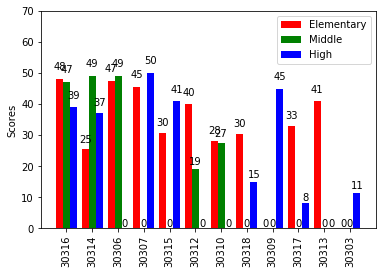

In [414]:
fig = plt.figure()
ax = fig.add_subplot(111)

N = len(zip_final_school_score['zipcode'])
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

yvals = zip_final_school_score['elementary_score']
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = zip_final_school_score['middle_score']
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = zip_final_school_score['high_score']
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')

ax.set_xticks(ind+width)
ax.set_xticklabels( (zip_final_school_score['zipcode']) )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Elementary', 'Middle', 'High'))
plt.xticks(rotation=90)
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
              ha='center', va='bottom')
plt.ylim(top=70)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.savefig('school_results.png')
plt.show()

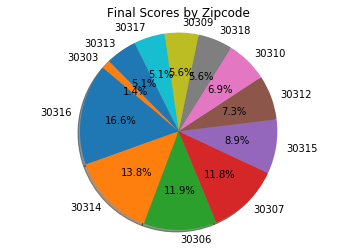

In [389]:
# Build Pie Chart
# Labels for the sections of our pie chart
labels = zip_final_school_score['zipcode']
labels
# # The values of each section of the pie chart
final_score =  zip_final_school_score['final_score']
final_score
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(final_score, explode=None, labels=labels,
       autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Final Scores by Zipcode")
plt.axis("equal")
# Save Figure
plt.savefig("./total_School_score_by_zipcode.png")
plt.show()

In [392]:
gtpm_count = gtpm_count.reset_index()

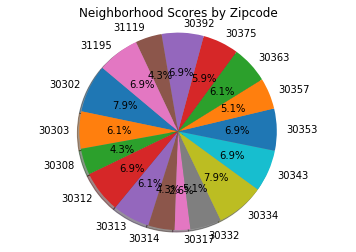

In [407]:
# Build Pie Chart
# Labels for the sections of our pie chart
labels = gtpm_count['zipcode']
labels
# # The values of each section of the pie chart
final_score = gtpm_count['total_score']
final_score
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(final_score, explode=None, labels=labels,
       autopct="%1.1f%%", shadow=True, startangle=140)
plt.title("Neighborhood Scores by Zipcode")
plt.axis("equal")
# Save Figure
plt.savefig("./neighborhood_scores.png")
plt.show()

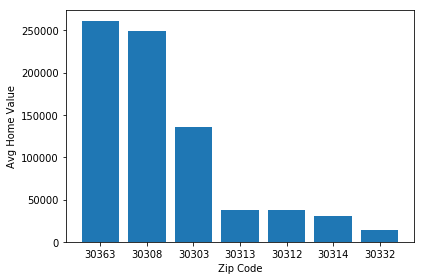

In [394]:
plt.bar(price_neighborhood_final_df['zipcode'], price_neighborhood_final_df['avg_mkt_val'])
plt.ylabel('Avg Home Value')
plt.xlabel('Zip Code')
plt.tight_layout()
plt.savefig('price_analysis.png')

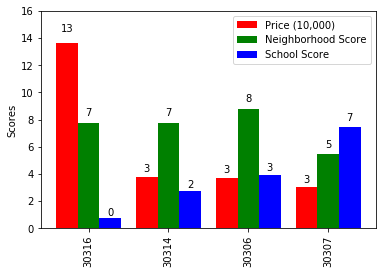

In [417]:
fig = plt.figure()
ax = fig.add_subplot(111)

N = len(final_combined_df['zipcode'])
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

yvals = final_combined_df['avg_mkt_val'] / 10000
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = final_combined_df['neighborhood_score']
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = final_combined_df['school_score']
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')

ax.set_xticks(ind+width)
ax.set_xticklabels( (zip_final_school_score['zipcode']) )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Price (10,000)', 'Neighborhood Score', 'School Score'))
plt.xticks(rotation=90)
def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
              ha='center', va='bottom')

plt.ylim(top=16)
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.savefig('final_results.png')
plt.show()

In [396]:
gtpm_count.head()

,zipcode,score_grocery_stores,score_police_stations,score_transit_stations,score_museums,total_score
0,30302,10,10,10,10,10.00
1,30303,1,10,10,10,7.75
2,30308,10,1,10,1,5.50
3,30312,5,10,10,10,8.75
4,30313,1,10,10,10,7.75


In [397]:
zip_final_school_score.head()

,zipcode,high_score,middle_score,elementary_score,final_score
5,30316,39.0,47.0,48.000000,8.933333
3,30314,37.0,49.0,25.500000,7.433333
8,30306,0.0,49.0,47.500000,6.433333
1,30307,50.0,0.0,45.500000,6.366667
4,30315,41.0,0.0,30.833333,4.788889


In [398]:
price_neighborhood_final_df.head()

,zipcode,total_score,avg_mkt_val
6,30363,7.75,261123.71
1,30308,5.50,249129.35
0,30303,7.75,136101.63
3,30313,7.75,38016.63
2,30312,8.75,37320.32


In [399]:
final_combined_df

,zipcode,avg_mkt_val,neighborhood_score,school_score
0,30303,136101.63,7.75,0.766667
1,30313,38016.63,7.75,2.733333
2,30312,37320.32,8.75,3.933333
3,30314,30652.85,5.50,7.433333
